In [1]:
from base import *
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score
from xgboost import XGBClassifier
import scipy
import time

In [2]:
LIAR = Dataset('./liar_dataset')

TEXT_TRAIN = LIAR.train['statement'].apply(text_preprocess)
TEXT_TEST = LIAR.test['statement'].apply(text_preprocess)

CT_TRAIN = LIAR.train['context'].apply(context_preprocess)
CT_TEST = LIAR.test['context'].apply(context_preprocess)

SJ_TRAIN = LIAR.train['subject'].apply(subject_preprocess)
SJ_TEST = LIAR.test['subject'].apply(subject_preprocess)

JOB_TRAIN = LIAR.train['job'].apply(job_preprocess)
JOB_TEST = LIAR.test['job'].apply(job_preprocess)

ST_TRAIN = LIAR.train['state'].str.lower()
ST_TEST = LIAR.test['state'].str.lower()

AF_TRAIN = LIAR.train['affiliation'].str.lower()
AF_TEST = LIAR.test['affiliation'].str.lower()

In [3]:
tfidf = TfidfVectorizer()
cvtr = CountVectorizer(binary=True)

ct_train = tfidf.fit_transform(CT_TRAIN)
ct_test = tfidf.transform(CT_TEST)
sj_train = cvtr.fit_transform(SJ_TRAIN)
sj_test = cvtr.transform(SJ_TEST)
job_train = cvtr.fit_transform(JOB_TRAIN)
job_test = cvtr.transform(JOB_TEST)
st_train = cvtr.fit_transform(ST_TRAIN)
st_test = cvtr.transform(ST_TEST)
af_train = cvtr.fit_transform(AF_TRAIN)
af_test = cvtr.transform(AF_TEST)

context_train = scipy.sparse.hstack(( ct_train, sj_train, job_train, st_train, af_train ))
context_test = scipy.sparse.hstack(( ct_test, sj_test, job_test, st_test, af_test ))

text_train = tfidf.fit_transform(TEXT_TRAIN)
text_test = tfidf.transform(TEXT_TEST)

data_train = (text_train, context_train)
data_test = (text_test, context_test)

## Proposed method

In [4]:
class ProposedMethod():
    def __init__(self):

        self.prediction = None
        self.final_model = XGBClassifier(
                                n_estimators = 100,
                                objective = 'multi:softmax',
                                learning_rate = .1,
                                max_depth = 3)

        self.text_models = [
            XGBClassifier(
                n_estimators = 100,
                learning_rate = .3,
                max_depth = 2),

            XGBClassifier(
                n_estimators = 50,
                learning_rate = .3,
                max_depth = 2),

            XGBClassifier(
                n_estimators = 50,
                learning_rate = .1,
                max_depth = 2),

            XGBClassifier(
                n_estimators = 100,
                learning_rate = .3,
                max_depth = 2),
        ]
        
        self.context_models = [
            XGBClassifier(
                n_estimators = 100,
                learning_rate = .3,
                max_depth = 2),

            XGBClassifier(
                n_estimators = 50,
                learning_rate = .3,
                max_depth = 2),

            XGBClassifier(
                n_estimators = 50,
                learning_rate = .1,
                max_depth = 2),

            XGBClassifier(
                n_estimators = 100,
                learning_rate = .3,
                max_depth = 2),
        ]

        self.final_map = {
            'pants-fire'  : 0, 
            'false'       : 1, 
            'barely-true' : 2, 
            'half-true'   : 3, 
            'mostly-true' : 4, 
            'true'        : 5
        }
        
        self.maps = [
            {
                'pants-fire'  : 0, 
                'false'       : 0, 
                'barely-true' : 1, 
                'half-true'   : 1, 
                'mostly-true' : 1, 
                'true'        : 1
            },
            {
                'pants-fire'  : 0, 
                'false'       : 0, 
                'barely-true' : 1, 
                'half-true'   : 1, 
                'mostly-true' : 0, 
                'true'        : 0
            },
            {
                'pants-fire'  : 0, 
                'false'       : 0, 
                'barely-true' : 0, 
                'half-true'   : 0, 
                'mostly-true' : 1, 
                'true'        : 1
            },
            {
                'pants-fire'  : 0, 
                'false'       : 0, 
                'barely-true' : 0, 
                'half-true'   : 1, 
                'mostly-true' : 1, 
                'true'        : 1
            }
        ]
        self.delabel = {
            0 : 'pants-fire', 
            1 : 'false'     ,
            2 : 'barely-true',
            3 : 'half-true'  ,
            4 : 'mostly-true',
            5 : 'true'
        }
        self.scaler = MinMaxScaler()
    
    def fit_(self, X, y):
        base_preds = np.empty((y.shape[0], 8))
        for i in range(4):
            start = time.time()
            y_ = y.map(self.maps[i])
            X_ = X[0]
            self.text_models[i].fit(X_, y_)
            base_preds[:, i] = self.text_models[i].predict_proba(X_)[:, 0]
            end = time.time()
            execution_time = end - start
            print(f'Model {i+1}:')
            print(f'accuracy: {accuracy_score(y_, self.text_models[i].predict(X_))*100:.2f} %')
            print(f'execution time: {execution_time:.2f}s')
            
        for i in range(4):
            start = time.time()
            y_ = y.map(self.maps[i])
            X_ = X[1]
            self.context_models[i].fit(X_, y_)
            base_preds[:, i+4] = self.context_models[i].predict_proba(X_)[:, 0]
            end = time.time()
            execution_time = end - start
            print(f'Model {i+5}:')
            print(f'accuracy: {accuracy_score(y_, self.context_models[i].predict(X_))*100:.2f} %')
            print(f'execution time: {execution_time:.2f}s')

        start = time.time()
        y_ = y.map(self.final_map)
        X_ = base_preds
        X_ = self.scaler.fit_transform(X_)
        
        self.final_model.fit(X_, y_)
        end = time.time()
        execution_time = end - start
        print('-'*60)
        print('Final model:')
        print(f'accuracy: {accuracy_score(y_, self.final_model.predict(X_))*100:.2f} %')
        print(f'execution time: {execution_time:.2f}s')

    def predict_(self, X, y):
        base_preds = np.empty((y.shape[0], 8))
        for i in range(4):
            start = time.time()
            y_ = y.map(self.maps[i])
            X_ = X[0]
            base_preds[:, i] = self.text_models[i].predict_proba(X_)[:, 0]
            end = time.time()
            execution_time = end - start
            print(f'Model {i}:')
            print(f'accuracy: {accuracy_score(y_, self.text_models[i].predict(X_))*100:.2f} %')
            print(f'execution time: {execution_time:.2f}s')
        for i in range(4):
            start = time.time()
            y_ = y.map(self.maps[i])
            X_ = X[1]
            base_preds[:, i+4] = self.context_models[i].predict_proba(X_)[:, 0]
            end = time.time()
            execution_time = end - start
            print(f'Model {i}:')
            print(f'accuracy: {accuracy_score(y_, self.context_models[i].predict(X_))*100:.2f} %')
            print(f'execution time: {execution_time:.2f}s')
        start = time.time()
        y_ = y.map(self.final_map)
        X_ = base_preds
        X_ = self.scaler.transform(X_)
        
        self.prediction = self.final_model.predict(X_)
        end = time.time()
        execution_time = end - start
        print('-'*60)
        print('Final model:')
        print(f'accuracy: {accuracy_score(y_, self.prediction)*100:.2f} %')
        print(f'execution time: {execution_time:.2f}s')
        return self.prediction

    
    def fit(self, X, y):
        base_preds = np.empty((y.shape[0], 8))
        for i in range(4):
            y_ = y.map(self.maps[i])
            X_ = X[0]
            self.text_models[i].fit(X_, y_)
            base_preds[:, i] = self.text_models[i].predict_proba(X_)[:, 0]
            
        for i in range(4):
            y_ = y.map(self.maps[i])
            X_ = X[1]
            self.context_models[i].fit(X_, y_)
            base_preds[:, i+4] = self.context_models[i].predict_proba(X_)[:, 0]
        y_ = y.map(self.final_map)
        X_ = base_preds
        X_ = self.scaler.fit_transform(X_)
        self.final_model.fit(X_, y_)

    def predict(self, X):
        base_preds = np.empty((X[0].shape[0], 8))
        for i in range(4):
            X_ = X[0]
            base_preds[:, i] = self.text_models[i].predict_proba(X_)[:, 0]
        for i in range(4):
            X_ = X[1]
            base_preds[:, i+4] = self.context_models[i].predict_proba(X_)[:, 0]
        X_ = base_preds
        X_ = self.scaler.transform(X_)
        self.prediction = self.final_model.predict(X_)
        return [self.delabel[x] for x in self.prediction]
        

In [5]:
clf = ProposedMethod()
start = time.time()
clf.fit(data_train, LIAR.y_train)
end = time.time()
execution_time = end - start
print(f'Model training time: {execution_time:.2f}s')

Model training time: 5.17s


In [6]:
print('Details on training phase')
clf.fit_(data_train, LIAR.y_train)
print()
print('Details on testing phase')
print('='*60)
pred = clf.predict_(data_test, LIAR.y_test)

Details on training phase
Model 1:
accuracy: 73.38 %
execution time: 1.51s
Model 2:
accuracy: 65.05 %
execution time: 0.67s
Model 3:
accuracy: 65.10 %
execution time: 0.76s
Model 4:
accuracy: 65.57 %
execution time: 1.43s
Model 5:
accuracy: 74.51 %
execution time: 0.21s
Model 6:
accuracy: 64.46 %
execution time: 0.09s
Model 7:
accuracy: 65.19 %
execution time: 0.09s
Model 8:
accuracy: 64.80 %
execution time: 0.26s
------------------------------------------------------------
Final model:
accuracy: 40.79 %
execution time: 0.37s

Details on testing phase
Model 0:
accuracy: 73.81 %
execution time: 0.00s
Model 1:
accuracy: 63.21 %
execution time: 0.01s
Model 2:
accuracy: 64.46 %
execution time: 0.00s
Model 3:
accuracy: 59.94 %
execution time: 0.00s
Model 0:
accuracy: 74.20 %
execution time: 0.00s
Model 1:
accuracy: 62.82 %
execution time: 0.00s
Model 2:
accuracy: 64.46 %
execution time: 0.00s
Model 3:
accuracy: 61.89 %
execution time: 0.00s
--------------------------------------------------

In [7]:
pred = clf.predict(data_test)
print(classification_report(LIAR.y_test, pred))

              precision    recall  f1-score   support

 barely-true       0.29      0.23      0.25       214
       false       0.28      0.45      0.34       250
   half-true       0.24      0.23      0.24       267
 mostly-true       0.24      0.34      0.28       249
  pants-fire       0.48      0.15      0.23        92
        true       0.25      0.10      0.14       211

    accuracy                           0.27      1283
   macro avg       0.30      0.25      0.25      1283
weighted avg       0.28      0.27      0.25      1283



<Figure size 1000x700 with 0 Axes>

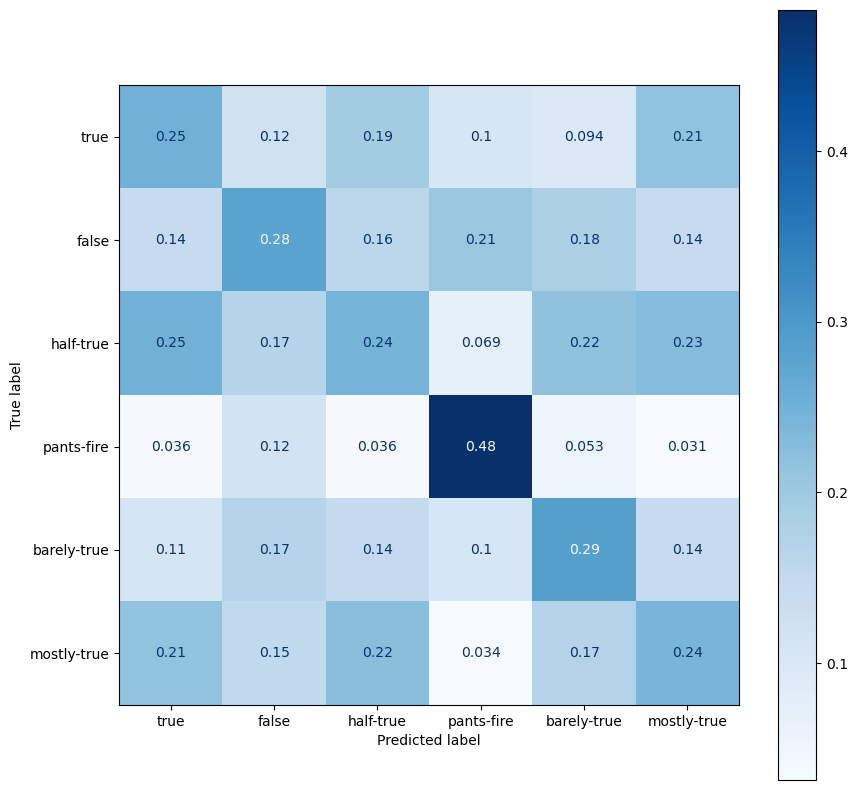

In [8]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))

cm = confusion_matrix(LIAR.y_test, pred, labels= LIAR.y_test.unique(), normalize='pred')
cmp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=LIAR.y_test.unique())
fig, ax = plt.subplots(figsize=(10,10))
cmp.plot(cmap = 'Blues', ax=ax);
